In [12]:
from general import *
from classes import LIF
import statsmodels.api as sm
from statsmodels.formula.api import ols

create_folder_if_not_exists('images')
create_folder_if_not_exists('images/position_neuron')

Folder 'images' already exists.
Folder 'images/position_neuron' already exists.


In [13]:
with open('data/spike_sensory', 'rb') as file:
    spike_sensory = np.load(file) 
    
with open('data/joint_angles_' + parameters['joint_string'], 'rb') as file:
    joint_angles = np.load(file)

time = np.linspace(0, constants['T_TOTAL'], num=constants['N_STEPS'])

position_parameters_uni = {'tau': 160e-3, 'V_T': -50e-3, 'V_R': -70e-3, 'n': constants['N_ANGLES'], 'w': 10e-3,
                           'N_input': parameters['N_HAIRS'], 'dt': constants['dt'], 'refrac': 0}

position_parameters_bi = {'tau': 160e-3, 'V_T': -50e-3, 'V_R': -70e-3, 'n': 2 * constants['N_ANGLES'], 'w': 10e-3,
                           'N_input': parameters['N_HAIRS'] // 2, 'dt': constants['dt'], 'refrac': 0}

position_neuron_uni = LIF(position_parameters_uni)
position_neuron_uni.initialize_state()
position_neuron_bi = LIF(position_parameters_bi)
position_neuron_bi.initialize_state()

spike_position_uni = np.empty((constants['N_STEPS'], position_parameters_uni['n'], parameters['N_SIMULATIONS']), dtype=np.uint8)
spike_position_bi = np.empty((constants['N_STEPS'], position_parameters_bi['n'], parameters['N_SIMULATIONS']), dtype=np.uint8)

In [14]:
for k in tqdm(range(parameters['N_SIMULATIONS'])):    
    for i in range(constants['N_STEPS']):    
        reshaped_spikes = np.reshape(spike_sensory[i, :, k], (position_parameters_bi['n'], (parameters['N_HAIRS'])))
        
        _, spike_position_uni[i, :, k] = position_neuron_uni.forward(reshaped_spikes[:18, :])
        _, spike_position_bi[i, :, k] = position_neuron_bi.forward(reshaped_spikes[:, parameters['N_HAIRS'] // 2:])
        
with open('data/spike_position', 'wb') as file:
        np.save(file, spike_position_bi)

  0%|          | 0/2 [00:00<?, ?it/s]

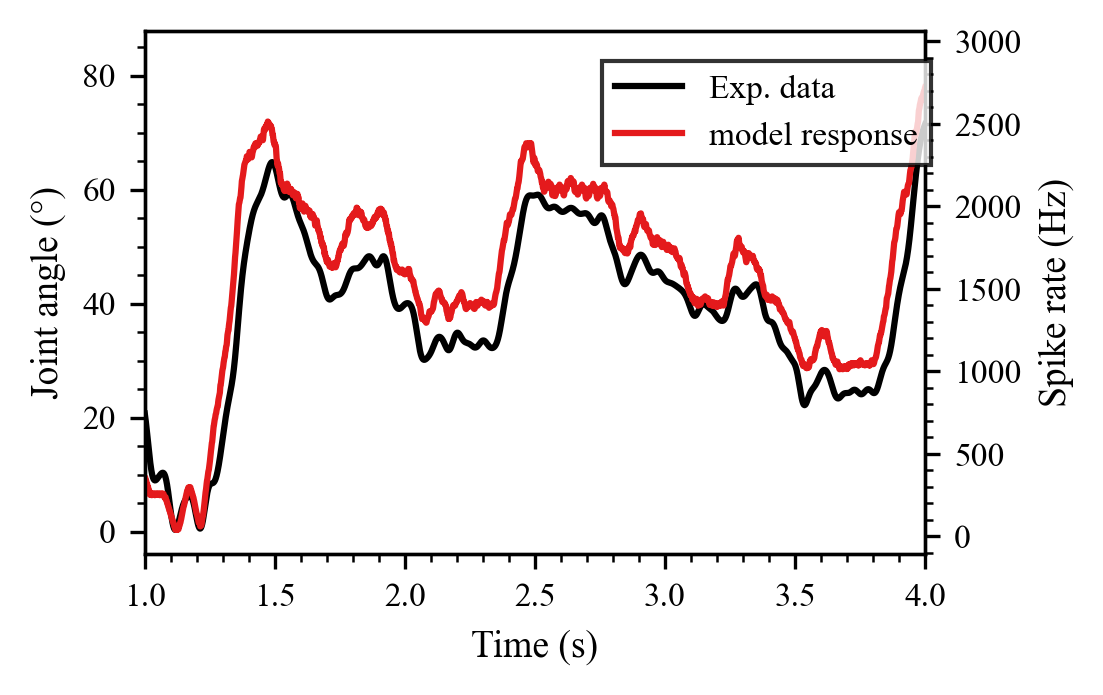

In [15]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

firing_rate = get_firing_rate_convolve(spike_position_uni[:, 1, 0], constants['dt'], 0.05)

ax2.plot(time, firing_rate, color=custom_colors[0], linestyle=custom_linestyles[0], label='model response')

ax1.plot(time, joint_angles[:, 0, 0], color='black', label='Exp. data')

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Joint angle (°)")
ax1.minorticks_on()
ax2.minorticks_on()

ax1.set_xlim([1, 4])
ax2.set_xlim([1, 4])
fig.legend(loc='lower right', fancybox=False, edgecolor='black', bbox_to_anchor=[0.87, 0.75])

ax2.set_ylabel("Spike rate (Hz)")

fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/position_neuron/uni_position_din_.png')

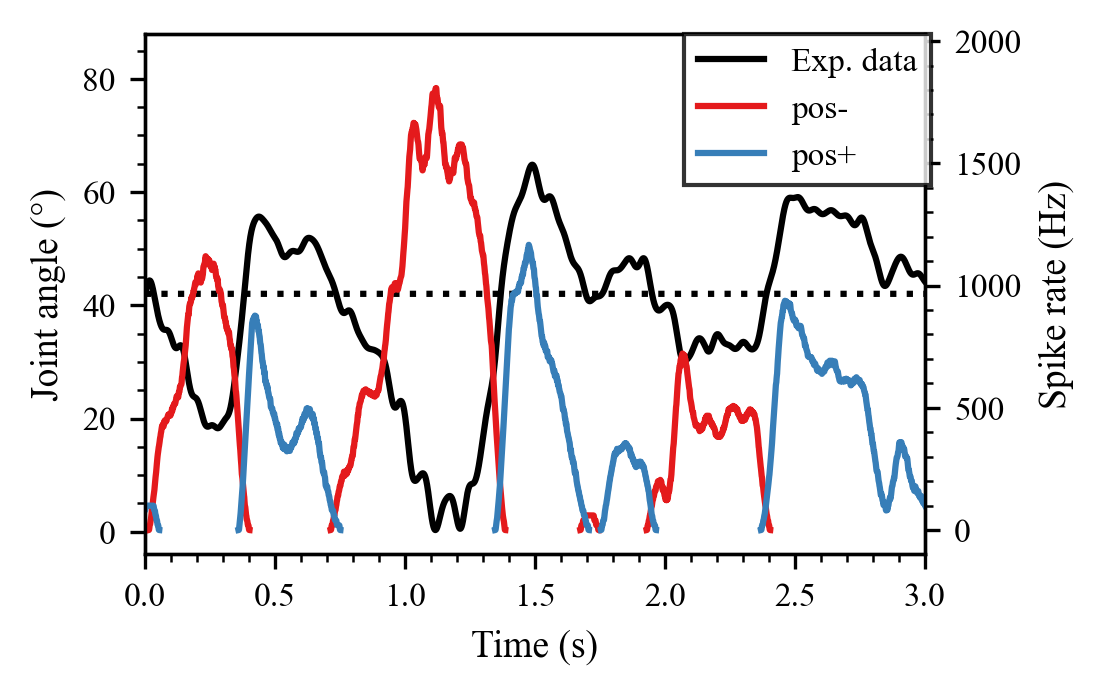

In [16]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

handles = ['pos-', 'pos+']

for i in range(2):
    firing_rate = get_firing_rate_convolve(spike_position_bi[:, i, 0], constants['dt'], 0.05)
    ax2.plot(time, firing_rate, color=custom_colors[i], label = handles[i])


ax1.plot(time, joint_angles[:, 0, 0], color='black', label='Exp. data')
ax1.plot(time, np.full(len(time), np.max(joint_angles[:, 0, 0]) / 2 + np.min(joint_angles[:, 0, 0]) / 2), linestyle='dotted',
         color='black')

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Joint angle (°)")
ax1.minorticks_on()
ax2.minorticks_on()

ax1.set_xlim([0, 3])
ax2.set_xlim([0, 3])
fig.legend(loc='lower right', fancybox=False, edgecolor='black', bbox_to_anchor=[0.87, 0.72])

ax2.set_ylabel("Spike rate (Hz)")

fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/position_neuron/bi_position_din_.png')

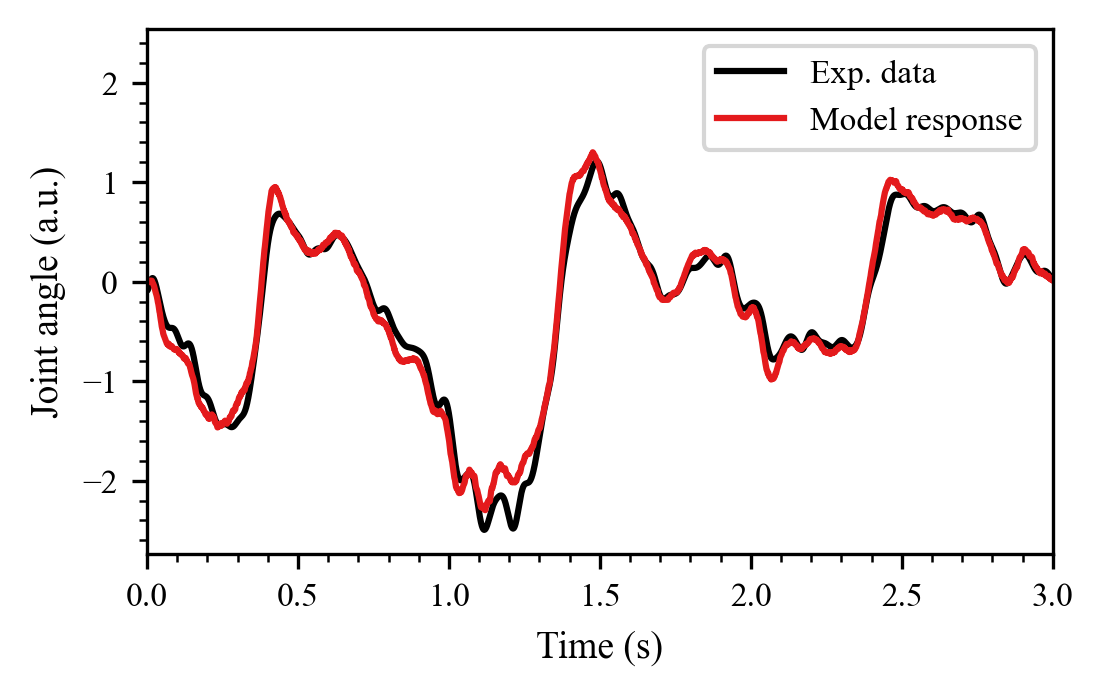

In [17]:
firing_rate_down = get_firing_rate_convolve(spike_position_bi[:, 0, 0], constants['dt'], 0.05, nan_bool=False)
firing_rate_up = get_firing_rate_convolve(spike_position_bi[:, 1, 0], constants['dt'], 0.05, nan_bool=False)

combined_firing_rate = firing_rate_up - firing_rate_down

combined_firing_rate_norm = zscore.zscore(combined_firing_rate)
joint_angle_norm = zscore.zscore(joint_angles[:, 0, 0])

fig, ax = plt.subplots()

ax.plot(time, joint_angle_norm, color='black', label='Exp. data')
ax.plot(time, combined_firing_rate_norm, color=custom_colors[0], label = 'Model response')

ax.set_xlim([0, 3])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Joint angle (a.u.)")
ax.minorticks_on()
ax.legend()

fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/position_neuron/combined_position_din_.png')

In [18]:
N_GRID = 8
N_ANGLES = 18
weight_list = np.linspace(1e-3, 8e-3, num=N_GRID)
tau_list = np.linspace(40e-3, 180e-3, num=N_GRID)
MSE =  np.empty((N_ANGLES, parameters['N_SIMULATIONS'], N_GRID, N_GRID))
euclidean_norm = lambda x, y: np.abs(x - y)

for l, m in tqdm(np.ndindex(N_GRID, N_GRID), desc=f'Total {N_GRID*N_GRID}'): 
    position_parameters_bi['w'] = weight_list[l]
    position_parameters_bi['tau'] = tau_list[m]
    
    position_neuron_bi = LIF(position_parameters_bi)
    position_neuron_bi.initialize_state()
    
    for k in range(parameters['N_SIMULATIONS']):  
        for i in range(constants['N_STEPS']):       
           reshaped_spikes = np.reshape(spike_sensory[i, :, k], (position_parameters_bi['n'], (parameters['N_HAIRS'])))
        
           _, spike_position_bi[i, :, k] = position_neuron_bi.forward(reshaped_spikes[:, parameters['N_HAIRS'] // 2:])
        
        for i in range(N_ANGLES):
        
            firing_rate_down = get_firing_rate_convolve(spike_position_bi[:, 0 + 2*i, k], constants['dt'], 0.05, nan_bool=False)
            firing_rate_up = get_firing_rate_convolve(spike_position_bi[:, 1 + 2*i, k], constants['dt'], 0.05, nan_bool=False)
            
            
            combined_firing_rate = firing_rate_up - firing_rate_down
                      
            combined_firing_rate = zscore.zscore(combined_firing_rate)

            joint_angle = zscore.zscore(joint_angles[:, i, k])
                      
            MSE[i, k, l, m] = np.mean((combined_firing_rate - joint_angle)**2)

Total 64: 0it [00:00, ?it/s]

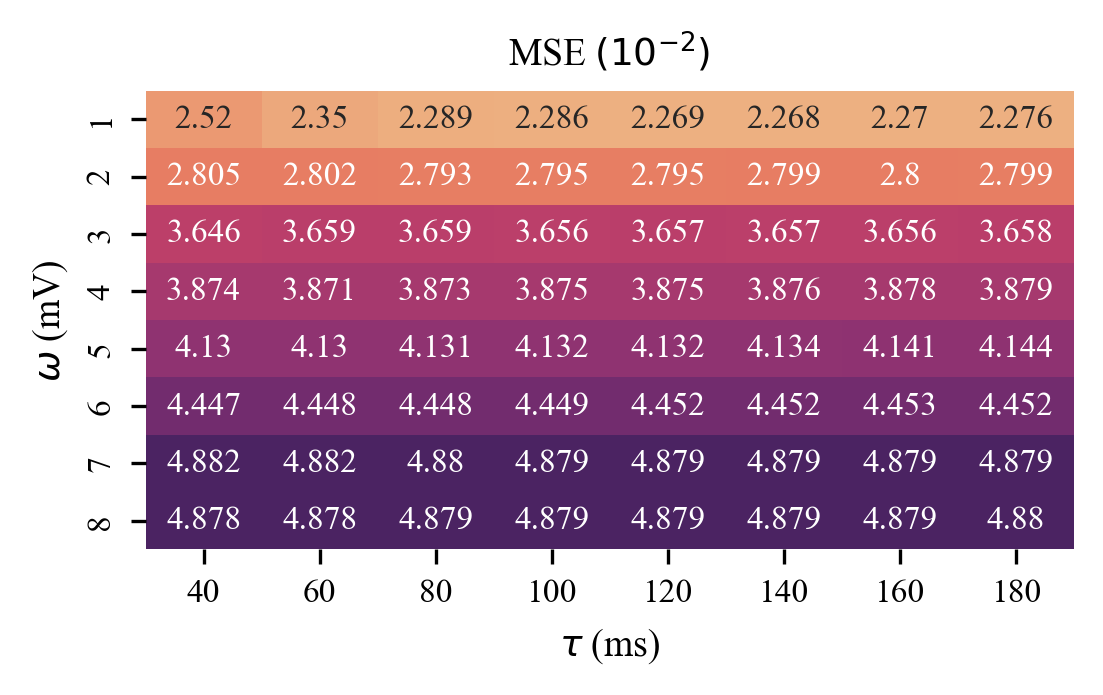

In [19]:
import seaborn as sns

MSE_mean = np.mean(MSE*100, axis=(0, 1))

df = pd.DataFrame(MSE_mean, index=np.round(weight_list*1E3).astype(int), columns=np.round(tau_list*1E3).astype(int))
fig, ax = plt.subplots()
heatmap = sns.heatmap(data=df, annot=True, fmt='.4g', cbar_kws={'label': 'MSE $(10^{-2})$'}, cbar=False, cmap='flare', annot_kws={"fontsize":8})
heatmap.set(ylabel='$\omega$ (mV)', xlabel=r'$\tau$ (ms)')

ax.set_title('MSE $(10^{-2})$')

fig.tight_layout(pad=parameters['pad'])
fig.savefig('images/position_neuron/position_heatmap.png')

In [20]:
MSE_opt = MSE[:, :, 0, 5]

MSE_opt = np.mean(MSE_opt, axis=1)

legs = np.tile(np.repeat(['front', 'middle', 'hind'], 3), 2)
joints = np.tile(['alpha', 'beta', 'gamma'], 6)

df = pd.DataFrame({'leg': legs,
                   'joint': joints,
                   'MSE': MSE_opt})

print(df)

       leg  joint       MSE
0    front  alpha  0.019665
1    front   beta  0.023382
2    front  gamma  0.019757
3   middle  alpha  0.020040
4   middle   beta  0.042197
5   middle  gamma  0.017865
6     hind  alpha  0.016255
7     hind   beta  0.022662
8     hind  gamma  0.030981
9    front  alpha  0.017338
10   front   beta  0.021520
11   front  gamma  0.019063
12  middle  alpha  0.016647
13  middle   beta  0.030181
14  middle  gamma  0.021663
15    hind  alpha  0.019504
16    hind   beta  0.031122
17    hind  gamma  0.018396


In [21]:
model = ols('MSE ~ C(leg) + C(joint) + C(leg):C(joint)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(leg),0.000067,2.0,1.429400,0.289007
C(joint),0.000334,2.0,7.149594,0.013838
C(leg):C(joint),0.000165,4.0,1.767982,0.219287
Residual,0.000210,9.0,NaN,NaN


In [22]:
MSE_leg = [np.mean(MSE_opt[np.where(legs==string)[0]]) for string in ['front', 'middle', 'hind']]
MSE_joint = [np.mean(MSE_opt[np.where(joints==string)[0]]) for string in ['alpha', 'beta', 'gamma']]

df = pd.DataFrame({'leg': ['front', 'middle', 'hind'],
                   'MSE leg': MSE_leg,
                   'joint': ['alpha', 'beta', 'gamma'],
                   'MSE joint': MSE_joint})

print(df)

      leg   MSE leg  joint  MSE joint
0   front  0.020121  alpha   0.018242
1  middle  0.024766   beta   0.028511
2    hind  0.023153  gamma   0.021287
